In [8]:
import os
import math
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib import cm
from scipy import stats
from scipy import optimize
from scipy import integrate
import scipy.linalg as la
import numpy.polynomial.polynomial as poly
from bisect import bisect_left
import pprint

In [9]:
def import_file(path, limit_low=None, limit_high=None):

    spectrum = np.genfromtxt(path, delimiter=",")
    spectrum = np.transpose(spectrum)
    wavenumbers = spectrum[0]
    intensities = spectrum[1]

    if limit_low is not None:
        limit_low_index = list(wavenumbers).index(limit_low)
    else:
        limit_low_index = 0
        limit_low = wavenumbers[0]

    if limit_high is not None:
        limit_high_index = list(wavenumbers).index(limit_high)
    else:
        limit_high_index = len(wavenumbers)
        limit_high = wavenumbers[-1]

    wavenumbers = wavenumbers[limit_low_index:limit_high_index]
    intensities = intensities[limit_low_index:limit_high_index]
    return wavenumbers, intensities

def import_directory(path, limit_low=None, limit_high=None):
    if not path.endswith("/"):
        path = path + "/"
    
    files = os.listdir(path)
    files = [file for file in files if file.lower().endswith(".txt")]
    
    files = sorted(files, key=lambda s: int(s[s.find("(")+1:s.find(")")]))
    
    
    wavenumbers = []
    intensities = []
        
    for file in files:
        wns, ints = import_file(path + file, limit_low, limit_high)
        wavenumbers.append(wns)
        intensities.append(ints)
    return np.array(wavenumbers), np.array(intensities), files

In [10]:
wavenumbers, intensities, files = import_directory("spectra", 300, 1600)

In [11]:
##################################
# Parameters for 4S Peak Filling #
##################################

penalty = 0         # Smoothing strength, starting value: 4
half_width = 10      # Half width of suppression window, starting value: half width at half height of widest peak
iterations = 6     # Number of iterations of the suppression cycle, starting value: 10
buckets = 400       # Number of intervals the data is divided into, can also be an array of indices, starting value: 1/10 of the number of data points

In [12]:
dims = np.shape(intensities)
baseline = np.zeros(dims)
corrected = np.zeros(dims)

In [13]:
#############
# Smoothing #
#############

diag = np.zeros((5,5))
np.fill_diagonal(diag, 1)
middle = np.matmul(np.diff(diag, n=2, axis=0).T, np.diff(diag, n=2, axis=0))
zeros = np.zeros((2,5))

to_band = np.vstack((zeros, middle, zeros))
the_band = np.diag(to_band)

for i in range(1, 5):
    the_band = np.vstack((the_band, np.diag(to_band, -i)))
    
indices = [0,1] + [2] * (dims[1]-4) + [3,4]
dd = the_band[:, indices] * (10**penalty)
dd[2,] = dd[2,] + 1

ints_original = intensities[:,:]
intensities = la.solve_banded((2,2), dd, intensities.T).T
dd

array([[ 0.,  0.,  1., ...,  1.,  1.,  1.],
       [ 0., -2., -4., ..., -4., -4., -2.],
       [ 2.,  6.,  7., ...,  7.,  6.,  2.],
       [-2., -4., -4., ..., -4., -2.,  0.],
       [ 1.,  1.,  1., ...,  1.,  0.,  0.]])

(300.0, 1599.5)

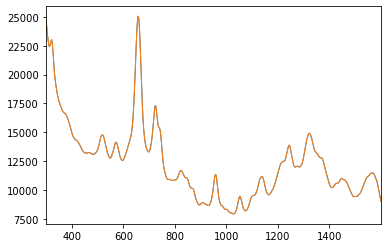

In [14]:
fig, ax = plt.subplots()
ax.plot(wavenumbers[0], ints_original[0], linewidth=1)
ax.plot(wavenumbers[0], intensities[0], linewidth=1)
ax.set_xlim((wavenumbers[0,0], wavenumbers[0,-1]))

In [15]:
if iterations != 1:
    d1 = math.log10(half_width)
    d2 = 0

    tmp = np.array(range(iterations-1)) * (d2 - d1) / (iterations - 1) + d1
    tmp = np.append(tmp, d2)
    w = np.ceil(10**tmp).astype(int)
else:
    w = np.array((half_width))

w

array([10,  7,  4,  3,  2,  1])

In [16]:
if isinstance(buckets, int):
    lims = np.linspace(0, dims[1]-1, buckets+1, dtype=int)
else:
    lims = buckets
    buckets = len(lims)-1
    
mids = np.rint(np.convolve(lims, np.ones(2), 'valid') / 2).astype(int)
mids[0] = 0
mids[-1] = dims[1]-1

In [17]:
%matplotlib
for s in range(dims[0]):
    
    ###############
    # Subsampling #
    ###############
    
    xx = np.zeros(buckets)
    for i in range(buckets):
        xx[i] = np.min(intensities[s, lims[i]:lims[i+1]])
        
    ###############
    # Suppression #
    ###############
    
    if s == 0:
        fig, ax = plt.subplots()
        ax.plot(wavenumbers[0], ints_original[0])
        ax.set_xlim((wavenumbers[0,0], wavenumbers[0,-1]))
        ax.invert_xaxis()
        
    
    for i in range(iterations):
        w0 = w[i]
        
        for j in range(1, buckets):
            v = min(j, w0, buckets-j)
            a = np.mean(xx[j-v:j+v+1])
            xx[j] = min(a, xx[j])
            
        if s == 0:
            ax.plot(wavenumbers[0, mids], xx, linewidth=0.5)
            
        for j in range(buckets-1, 0, -1):
            v = min(j, w0, buckets-j)
            a = np.mean(xx[j-v:j+v+1])
            xx[j] = min(a, xx[j])
        
        if s == 0:
            ax.plot(wavenumbers[0, mids], xx, linewidth=0.5)
            
    ##############
    # Stretching #
    ##############
        
    xxx = np.interp(range(dims[1]), mids, xx)
    baseline[s] = xxx
    corrected[s] = ints_original[s] - baseline[s]

Using matplotlib backend: Qt5Agg


In [18]:
corrected_sg2 = sig.savgol_filter(x=corrected,
                                  window_length=33,
                                  polyorder=3,
                                  deriv=2)

peaks = []
peaks_height = []
for i, row in enumerate(corrected_sg2):
    threshold = 0.05 + np.max(corrected[i])/30000
#     print(i, threshold)
    peaks_tmp = sig.argrelmin(row)[0]
    peaks_tmp = [peak for peak in peaks_tmp if row[peak] < -threshold]
    
    peak_condensing = []
    peaks_tmp2 = []
    for j in range(len(row)):
        if j in peaks_tmp:
            peak_condensing.append(j)
        if row[j] > 0 and len(peak_condensing) > 0:
            peaks_tmp2.append(int(np.mean(peak_condensing)))
            peak_condensing = []
    if len(peak_condensing) > 0:
        peaks_tmp2.append(int(np.mean(peak_condensing)))
    
    heights = [corrected[i, k] for k in peaks_tmp2]
    
    peaks.append(peaks_tmp2)
    peaks_height.append(heights)
    

In [19]:
n_peaks = [len(row) for row in peaks]
total_areas = integrate.simpson(corrected, wavenumbers)
avg_area = [area/n for n, area in zip(n_peaks, total_areas)]
median_height = [np.median(row) for row in peaks_height]
avg_height = [np.mean(row) for row in peaks_height]

In [20]:
print("index\tn_peaks\ttotal_area\tavg_area\tmedian_height\tavg_height")
for i in range(len(corrected)):
    print(f"{i}\t{n_peaks[i]}\t{int(total_areas[i])}\t\t{int(avg_area[i])}\t\t{int(median_height[i])}\t\t{int(avg_height[i])}")

index	n_peaks	total_area	avg_area	median_height	avg_height
0	28	1121712		40061		1166		1620
1	33	957952		29028		731		1183
2	32	1173162		36661		1008		1399
3	33	161207		4885		124		253
4	26	204233		7855		188		351
5	26	598493		23018		522		964
6	25	314181		12567		304		549
7	28	608787		21742		576		912
8	34	501787		14758		349		630
9	30	1216818		40560		1052		1559
10	26	879236		33816		1002		1407
11	32	339100		10596		253		494
12	26	249361		9590		236		422
13	25	759265		30370		715		1233
14	24	419423		17475		470		730
15	32	710737		22210		651		923
16	29	1276743		44025		1365		1789
17	29	357839		12339		300		510
18	26	425506		16365		407		677
19	28	482525		17233		510		704
20	30	1593562		53118		1415		2108
21	32	225477		7046		220		325
22	39	425647		10914		381		506
23	24	234122		9755		218		415
24	27	281472		10424		245		458
25	28	1344799		48028		1161		1795
26	34	1552257		45654		1248		1883
27	31	452416		14594		426		668
28	34	1369589		40282		1082		1644
29	32	1560705		48772		1238		2060
30	28	1185530		42340		101

In [14]:
# %matplotlib

# for i in range(len(corrected)):

#     fig, ax = plt.subplots(2)

#     ax[0].plot(wavenumbers[i,], corrected[i,], linewidth=1)
#     ax[0].set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
#     ax[0].invert_xaxis()
#     ax[0].hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
#     ax[0].vlines(wavenumbers[i,peaks[i]], 0, np.max(corrected[i])*1.1, color="red", linewidth=0.5)
#     ax[0].grid()


#     ax[1].plot(wavenumbers[i,], corrected_sg2[i,], linewidth=1)
#     ax[1].set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
#     ax[1].invert_xaxis()
#     ax[1].hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
#     ax[1].grid()

In [21]:
%matplotlib

for i in range(len(corrected)):

    fig, ax = plt.subplots(2)
    ax[0].plot(wavenumbers[i,], ints_original[i,], linewidth=1)
    ax[0].plot(wavenumbers[i,], baseline[i,], linewidth=1)
    ax[0].set_xlim((wavenumbers[0,0], wavenumbers[0,-1]))
    ax[0].invert_xaxis()
    ax[0].grid()


    ax[1].plot(wavenumbers[i,], corrected[i,], linewidth=1)
    ax[1].set_xlim(wavenumbers[0,0], wavenumbers[0,-1])
    ax[1].hlines(0, wavenumbers[0,0], wavenumbers[0,-1], color="black", linewidth=0.5)
    ax[1].vlines(wavenumbers[i,peaks[i]], 0, np.max(corrected[i])*1.1, color="red", linewidth=0.5)
    ax[1].invert_xaxis()
    ax[1].grid()
    
    fig.suptitle(files[i])

Using matplotlib backend: Qt5Agg


<ipython-input-21-f0d41b101e83>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


In [17]:
%matplotlib

fig, ax = plt.subplots()
ax.plot(avg_area, avg_height, "bo")

Using matplotlib backend: Qt5Agg


In [18]:
files_by_total_area = [file for area, file in sorted(zip(total_areas, files))]
files_by_avg_area = [file for area, file in sorted(zip(avg_area, files))]
files_by_median_height = [file for height, file in sorted(zip(median_height, files))]
files_by_avg_height = [file for height, file in sorted(zip(avg_height, files))]
files_by_n_peaks = [file for n, file in sorted(zip(n_peaks, files))]

total_area_x_n_peaks = [n*area for n, area in zip(n_peaks, total_areas)]
files_by_area_x_peaks = [file for score, file in sorted(zip(total_area_x_n_peaks, files))]

avg_area_exp_peaks = [area**n for n, area in zip(n_peaks, avg_area)]
files_by_area_exp_peaks = [file for score, file in sorted(zip(avg_area_exp_peaks, files))]

avg_height_exp_peaks = [height**n for n, height in zip(n_peaks, avg_height)]
files_by_height_exp_peaks = [file for score, file in sorted(zip(avg_height_exp_peaks, files))]

median_height_exp_peaks = [height**n for n, height in zip(n_peaks, median_height)]
files_by_med_height_exp_peaks = [file for score, file in sorted(zip(median_height_exp_peaks, files))]

In [19]:
files_by_total_area

['E (12).TXT',
 'E (7).TXT',
 'E (8).TXT',
 'E (9).TXT',
 'E (10).TXT',
 'E (22).TXT',
 'E (19).TXT',
 'E (47).TXT',
 'E (11).TXT',
 'E (13).TXT',
 'E (5).TXT',
 'E (4).TXT',
 'E (6).TXT',
 'E (39).TXT',
 'E (18).TXT',
 'E (23).TXT',
 'E (26).TXT',
 'E (38).TXT',
 'E (43).TXT',
 'E (21).TXT',
 'E (40).TXT',
 'E (42).TXT',
 'E (50).TXT',
 'E (49).TXT',
 'E (2).TXT',
 'E (20).TXT',
 'E (44).TXT',
 'E (52).TXT',
 'E (54).TXT',
 'E (60).TXT',
 'E (51).TXT',
 'E (55).TXT',
 'E (25).TXT',
 'E (3).TXT',
 'E (48).TXT',
 'E (53).TXT',
 'E (41).TXT',
 'E (1).TXT',
 'E (24).TXT',
 'E (45).TXT',
 'E (59).TXT',
 'E (46).TXT',
 'E (56).TXT',
 'E (16).TXT',
 'E (15).TXT',
 'E (58).TXT',
 'E (14).TXT',
 'E (17).TXT',
 'E (57).TXT',
 'E (32).TXT',
 'E (29).TXT',
 'E (34).TXT',
 'E (37).TXT',
 'E (27).TXT',
 'E (35).TXT',
 'E (31).TXT',
 'E (36).TXT',
 'E (33).TXT',
 'E (30).TXT',
 'E (28).TXT']

In [20]:
files_by_avg_area

['E (10).TXT',
 'E (19).TXT',
 'E (22).TXT',
 'E (9).TXT',
 'E (11).TXT',
 'E (47).TXT',
 'E (13).TXT',
 'E (4).TXT',
 'E (6).TXT',
 'E (39).TXT',
 'E (23).TXT',
 'E (5).TXT',
 'E (18).TXT',
 'E (26).TXT',
 'E (38).TXT',
 'E (40).TXT',
 'E (43).TXT',
 'E (21).TXT',
 'E (8).TXT',
 'E (50).TXT',
 'E (2).TXT',
 'E (42).TXT',
 'E (12).TXT',
 'E (49).TXT',
 'E (20).TXT',
 'E (44).TXT',
 'E (60).TXT',
 'E (55).TXT',
 'E (51).TXT',
 'E (52).TXT',
 'E (54).TXT',
 'E (3).TXT',
 'E (25).TXT',
 'E (41).TXT',
 'E (7).TXT',
 'E (48).TXT',
 'E (53).TXT',
 'E (1).TXT',
 'E (24).TXT',
 'E (45).TXT',
 'E (46).TXT',
 'E (56).TXT',
 'E (15).TXT',
 'E (58).TXT',
 'E (59).TXT',
 'E (16).TXT',
 'E (17).TXT',
 'E (14).TXT',
 'E (57).TXT',
 'E (32).TXT',
 'E (34).TXT',
 'E (29).TXT',
 'E (31).TXT',
 'E (27).TXT',
 'E (37).TXT',
 'E (36).TXT',
 'E (35).TXT',
 'E (30).TXT',
 'E (33).TXT',
 'E (28).TXT']

In [21]:
files_by_median_height

['E (12).TXT',
 'E (9).TXT',
 'E (8).TXT',
 'E (22).TXT',
 'E (10).TXT',
 'E (47).TXT',
 'E (11).TXT',
 'E (19).TXT',
 'E (13).TXT',
 'E (39).TXT',
 'E (6).TXT',
 'E (4).TXT',
 'E (5).TXT',
 'E (23).TXT',
 'E (18).TXT',
 'E (26).TXT',
 'E (43).TXT',
 'E (40).TXT',
 'E (21).TXT',
 'E (42).TXT',
 'E (50).TXT',
 'E (2).TXT',
 'E (55).TXT',
 'E (49).TXT',
 'E (38).TXT',
 'E (44).TXT',
 'E (60).TXT',
 'E (52).TXT',
 'E (20).TXT',
 'E (54).TXT',
 'E (53).TXT',
 'E (51).TXT',
 'E (25).TXT',
 'E (24).TXT',
 'E (3).TXT',
 'E (41).TXT',
 'E (48).TXT',
 'E (45).TXT',
 'E (56).TXT',
 'E (58).TXT',
 'E (15).TXT',
 'E (1).TXT',
 'E (59).TXT',
 'E (17).TXT',
 'E (16).TXT',
 'E (46).TXT',
 'E (7).TXT',
 'E (14).TXT',
 'E (57).TXT',
 'E (32).TXT',
 'E (29).TXT',
 'E (37).TXT',
 'E (34).TXT',
 'E (27).TXT',
 'E (28).TXT',
 'E (33).TXT',
 'E (36).TXT',
 'E (35).TXT',
 'E (31).TXT',
 'E (30).TXT']

In [22]:
files_by_avg_height

['E (10).TXT',
 'E (19).TXT',
 'E (9).TXT',
 'E (11).TXT',
 'E (22).TXT',
 'E (47).TXT',
 'E (4).TXT',
 'E (13).TXT',
 'E (6).TXT',
 'E (39).TXT',
 'E (5).TXT',
 'E (23).TXT',
 'E (18).TXT',
 'E (38).TXT',
 'E (43).TXT',
 'E (26).TXT',
 'E (40).TXT',
 'E (21).TXT',
 'E (8).TXT',
 'E (50).TXT',
 'E (42).TXT',
 'E (2).TXT',
 'E (49).TXT',
 'E (20).TXT',
 'E (44).TXT',
 'E (12).TXT',
 'E (55).TXT',
 'E (60).TXT',
 'E (51).TXT',
 'E (52).TXT',
 'E (54).TXT',
 'E (3).TXT',
 'E (48).TXT',
 'E (25).TXT',
 'E (41).TXT',
 'E (53).TXT',
 'E (7).TXT',
 'E (1).TXT',
 'E (24).TXT',
 'E (45).TXT',
 'E (46).TXT',
 'E (15).TXT',
 'E (56).TXT',
 'E (59).TXT',
 'E (58).TXT',
 'E (16).TXT',
 'E (17).TXT',
 'E (14).TXT',
 'E (57).TXT',
 'E (32).TXT',
 'E (34).TXT',
 'E (29).TXT',
 'E (37).TXT',
 'E (27).TXT',
 'E (36).TXT',
 'E (35).TXT',
 'E (31).TXT',
 'E (33).TXT',
 'E (28).TXT',
 'E (30).TXT']

In [145]:
files_by_n_peaks

['E (7).TXT',
 'E (12).TXT',
 'E (8).TXT',
 'E (9).TXT',
 'E (10).TXT',
 'E (22).TXT',
 'E (5).TXT',
 'E (14).TXT',
 'E (28).TXT',
 'E (47).TXT',
 'E (18).TXT',
 'E (25).TXT',
 'E (33).TXT',
 'E (37).TXT',
 'E (59).TXT',
 'E (26).TXT',
 'E (27).TXT',
 'E (32).TXT',
 'E (35).TXT',
 'E (39).TXT',
 'E (49).TXT',
 'E (53).TXT',
 'E (54).TXT',
 'E (57).TXT',
 'E (13).TXT',
 'E (19).TXT',
 'E (36).TXT',
 'E (4).TXT',
 'E (48).TXT',
 'E (52).TXT',
 'E (6).TXT',
 'E (1).TXT',
 'E (11).TXT',
 'E (16).TXT',
 'E (20).TXT',
 'E (29).TXT',
 'E (3).TXT',
 'E (30).TXT',
 'E (43).TXT',
 'E (42).TXT',
 'E (44).TXT',
 'E (56).TXT',
 'E (17).TXT',
 'E (34).TXT',
 'E (38).TXT',
 'E (45).TXT',
 'E (51).TXT',
 'E (55).TXT',
 'E (15).TXT',
 'E (21).TXT',
 'E (24).TXT',
 'E (31).TXT',
 'E (50).TXT',
 'E (58).TXT',
 'E (60).TXT',
 'E (41).TXT',
 'E (46).TXT',
 'E (2).TXT',
 'E (23).TXT',
 'E (40).TXT']

In [136]:
files_by_area_x_peaks

['E (7).TXT',
 'E (12).TXT',
 'E (8).TXT',
 'E (9).TXT',
 'E (22).TXT',
 'E (10).TXT',
 'E (47).TXT',
 'E (19).TXT',
 'E (5).TXT',
 'E (11).TXT',
 'E (13).TXT',
 'E (4).TXT',
 'E (6).TXT',
 'E (39).TXT',
 'E (18).TXT',
 'E (26).TXT',
 'E (23).TXT',
 'E (43).TXT',
 'E (38).TXT',
 'E (49).TXT',
 'E (21).TXT',
 'E (42).TXT',
 'E (20).TXT',
 'E (50).TXT',
 'E (54).TXT',
 'E (40).TXT',
 'E (2).TXT',
 'E (52).TXT',
 'E (44).TXT',
 'E (25).TXT',
 'E (51).TXT',
 'E (60).TXT',
 'E (55).TXT',
 'E (3).TXT',
 'E (48).TXT',
 'E (53).TXT',
 'E (1).TXT',
 'E (41).TXT',
 'E (24).TXT',
 'E (59).TXT',
 'E (45).TXT',
 'E (14).TXT',
 'E (56).TXT',
 'E (16).TXT',
 'E (46).TXT',
 'E (15).TXT',
 'E (58).TXT',
 'E (17).TXT',
 'E (57).TXT',
 'E (32).TXT',
 'E (37).TXT',
 'E (27).TXT',
 'E (29).TXT',
 'E (35).TXT',
 'E (34).TXT',
 'E (33).TXT',
 'E (36).TXT',
 'E (31).TXT',
 'E (28).TXT',
 'E (30).TXT']

In [137]:
files_by_area_exp_peaks

['E (7).TXT',
 'E (12).TXT',
 'E (8).TXT',
 'E (9).TXT',
 'E (22).TXT',
 'E (10).TXT',
 'E (5).TXT',
 'E (47).TXT',
 'E (18).TXT',
 'E (19).TXT',
 'E (39).TXT',
 'E (13).TXT',
 'E (11).TXT',
 'E (4).TXT',
 'E (6).TXT',
 'E (26).TXT',
 'E (49).TXT',
 'E (25).TXT',
 'E (54).TXT',
 'E (43).TXT',
 'E (53).TXT',
 'E (14).TXT',
 'E (52).TXT',
 'E (20).TXT',
 'E (59).TXT',
 'E (48).TXT',
 'E (38).TXT',
 'E (42).TXT',
 'E (3).TXT',
 'E (44).TXT',
 'E (1).TXT',
 'E (21).TXT',
 'E (50).TXT',
 'E (51).TXT',
 'E (55).TXT',
 'E (57).TXT',
 'E (28).TXT',
 'E (37).TXT',
 'E (16).TXT',
 'E (32).TXT',
 'E (33).TXT',
 'E (23).TXT',
 'E (56).TXT',
 'E (60).TXT',
 'E (27).TXT',
 'E (45).TXT',
 'E (35).TXT',
 'E (2).TXT',
 'E (24).TXT',
 'E (40).TXT',
 'E (36).TXT',
 'E (17).TXT',
 'E (41).TXT',
 'E (29).TXT',
 'E (15).TXT',
 'E (58).TXT',
 'E (30).TXT',
 'E (46).TXT',
 'E (34).TXT',
 'E (31).TXT']

In [139]:
files_by_height_exp_peaks

['E (7).TXT',
 'E (12).TXT',
 'E (8).TXT',
 'E (9).TXT',
 'E (10).TXT',
 'E (22).TXT',
 'E (5).TXT',
 'E (47).TXT',
 'E (19).TXT',
 'E (18).TXT',
 'E (11).TXT',
 'E (39).TXT',
 'E (4).TXT',
 'E (13).TXT',
 'E (6).TXT',
 'E (26).TXT',
 'E (49).TXT',
 'E (43).TXT',
 'E (25).TXT',
 'E (54).TXT',
 'E (20).TXT',
 'E (52).TXT',
 'E (53).TXT',
 'E (38).TXT',
 'E (42).TXT',
 'E (48).TXT',
 'E (14).TXT',
 'E (59).TXT',
 'E (3).TXT',
 'E (44).TXT',
 'E (21).TXT',
 'E (50).TXT',
 'E (55).TXT',
 'E (1).TXT',
 'E (51).TXT',
 'E (23).TXT',
 'E (57).TXT',
 'E (16).TXT',
 'E (60).TXT',
 'E (2).TXT',
 'E (56).TXT',
 'E (40).TXT',
 'E (45).TXT',
 'E (37).TXT',
 'E (28).TXT',
 'E (24).TXT',
 'E (32).TXT',
 'E (33).TXT',
 'E (27).TXT',
 'E (35).TXT',
 'E (41).TXT',
 'E (17).TXT',
 'E (15).TXT',
 'E (58).TXT',
 'E (36).TXT',
 'E (29).TXT',
 'E (46).TXT',
 'E (30).TXT',
 'E (34).TXT',
 'E (31).TXT']

In [142]:
files_by_med_height_exp_peaks

['E (12).TXT',
 'E (7).TXT',
 'E (8).TXT',
 'E (9).TXT',
 'E (22).TXT',
 'E (10).TXT',
 'E (5).TXT',
 'E (47).TXT',
 'E (19).TXT',
 'E (39).TXT',
 'E (18).TXT',
 'E (13).TXT',
 'E (11).TXT',
 'E (6).TXT',
 'E (4).TXT',
 'E (26).TXT',
 'E (49).TXT',
 'E (43).TXT',
 'E (25).TXT',
 'E (53).TXT',
 'E (42).TXT',
 'E (54).TXT',
 'E (52).TXT',
 'E (20).TXT',
 'E (38).TXT',
 'E (14).TXT',
 'E (44).TXT',
 'E (55).TXT',
 'E (21).TXT',
 'E (3).TXT',
 'E (48).TXT',
 'E (50).TXT',
 'E (59).TXT',
 'E (23).TXT',
 'E (1).TXT',
 'E (51).TXT',
 'E (28).TXT',
 'E (40).TXT',
 'E (57).TXT',
 'E (45).TXT',
 'E (2).TXT',
 'E (60).TXT',
 'E (37).TXT',
 'E (24).TXT',
 'E (16).TXT',
 'E (56).TXT',
 'E (33).TXT',
 'E (32).TXT',
 'E (58).TXT',
 'E (27).TXT',
 'E (15).TXT',
 'E (41).TXT',
 'E (35).TXT',
 'E (17).TXT',
 'E (36).TXT',
 'E (29).TXT',
 'E (46).TXT',
 'E (34).TXT',
 'E (30).TXT',
 'E (31).TXT']

In [6]:
?

Object `plt.axes.Axes.tick_params` not found.


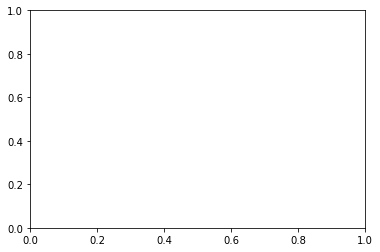

In [5]:
fig, ax = plt.subplots()
ax.set_yl